# CHASV_60model.v3.1, train threshold and new subgroup
split 7:3

In [1]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import joblib
from BorutaShap import BorutaShap
import tqdm

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [2]:
df = pd.read_csv("/home/danssa/proj_ua/data/chasv_development.v2.csv", dtype={'id':np.str})
df2 = df.loc[df['from']!="knhanes"]
df2.describe()

,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,dm,htn
count,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000
mean,0.067598,93.719380,0.428929,47.179829,6.183206,0.020280,1.018628,0.331024,0.234011,0.205590,0.039356,0.757068,0.168417,0.516135,0.025325,0.039046
std,0.251056,22.147902,0.494924,15.570474,0.824044,0.140957,0.007915,0.769946,0.888690,0.669646,0.324305,1.252923,0.560018,1.024153,0.157111,0.193706
min,0.000000,1.704754,0.000000,18.000000,5.000000,0.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.803010,0.000000,35.000000,5.500000,0.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,95.813740,0.000000,45.000000,6.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,110.264000,1.000000,58.000000,7.000000,0.000000,1.025000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,257.176000,1.000000,95.000000,9.000000,1.000000,1.030000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000


## train and test set : multi staratification (eGFR and age)

In [3]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         53.80721514 70.94886739 95.        ]
age0_edge: 53.807215139710536 
age1_edge: 70.94886739427912 
age2_edge: 95.0
age group:
 0    2104
1    5505
2    7264
Name: level, dtype: int64


In [4]:
##make 3group by age
df3 = df2.copy()

##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    147140
1     52377
2     20503
Name: level, dtype: int64


In [5]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.3, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.3, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test1 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.3, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 53
total cases = 147140
total abnormal function of kidney = 2104 
prevalence = 1.4299306782655974
train0 : 1473 test0 : 631

age1 54 70
total cases = 52377
total abnormal function of kidney = 5505 
prevalence = 10.510338507360101
train1 : 3853 test1 : 1652

age2 71 95
total cases = 20503
total abnormal function of kidney = 7264 
prevalence = 35.42896161537336
train2 : 5085 test2 : 2179


In [6]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 220020
total abnormal function of kidney = 14873 
prevalence = 6.759840014544133


## model features and standardization

In [7]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

154013 train cases, 12 variables
66007 test cases


In [8]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,154013.000000,1.540130e+05,1.540130e+05,154013.000000,1.540130e+05,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000
mean,0.428990,-2.362125e-17,3.380791e-16,0.020492,-1.550439e-14,0.330505,0.234565,0.206749,0.039802,0.754339,0.167538,0.518443
std,0.494933,1.000003e+00,1.000003e+00,0.141676,1.000003e+00,0.768392,0.888223,0.670159,0.325684,1.251279,0.558978,1.026045
min,0.000000,-1.875173e+00,-1.435489e+00,0.000000,-1.720897e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.828201e-01,-8.290850e-01,0.000000,-1.089132e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.402599e-01,-2.226811e-01,0.000000,1.743975e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,6.950684e-01,9.901268e-01,0.000000,8.061624e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,3.072541e+00,3.415742e+00,1.000000,1.437927e+00,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000


## initial model and final model fit

In [9]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : chasv_60model.v2
model = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                        nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean AUC: 0.915 (0.003)


In [10]:
# dimensionality reduction using feature importance
df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 12


,imp
he_uro,0.022157
leucocyte,0.024069
he_uket,0.024328
he_ubil,0.028265
male,0.040014
he_unitr,0.043089
he_uglu,0.056432
he_ubld,0.056874
he_uph,0.057655
he_usg,0.062921


In [11]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model: chasv_60model.v1
model_new = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                           nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model_new)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.914 (0.003)


## find out threshold all and subgroups in train set

In [17]:
df_train = X_train.copy()
df_train['prob'] = model_new.predict_proba(X_train_features_new)[:,1]

train_all = df_train.copy()
train_sub1 = df_train.query('dm==1')
train_sub2 = df_train.query('htn==1')
train_sub3 = df_train.query('age<65')
train_sub4 = df_train.query('age>=65')

In [18]:
print('train set')
print('total cases, prevalence (cases)')
print('train all: %d, %.1f (%d)' % (len(train_all), sum(train_all['eGFR_ab'])/len(train_all)*100, sum(train_all['eGFR_ab'])))
print('subgroup1: %d, %.1f (%d)' % (len(train_sub1), sum(train_sub1['eGFR_ab'])/len(train_sub1)*100, sum(train_sub1['eGFR_ab'])))
print('subgroup2: %d, %.1f (%d)' % (len(train_sub2), sum(train_sub2['eGFR_ab'])/len(train_sub2)*100, sum(train_sub2['eGFR_ab'])))
print('subgroup3: %d, %.1f (%d)' % (len(train_sub3), sum(train_sub3['eGFR_ab'])/len(train_sub3)*100, sum(train_sub3['eGFR_ab'])))
print('subgroup4: %d, %.1f (%d)' % (len(train_sub4), sum(train_sub4['eGFR_ab'])/len(train_sub4)*100, sum(train_sub4['eGFR_ab'])))

train set
total cases, prevalence (cases)
train all: 154013, 6.8 (10411)
subgroup1: 3942, 5.2 (205)
subgroup2: 5949, 2.5 (150)
subgroup3: 129228, 2.6 (3421)
subgroup4: 24785, 28.2 (6990)


In [22]:
# confidence intervals
def cical(box, alpha=0.95):
    p = ((1.0-alpha)/2.0)*100
    lower = max(0.0, np.percentile(box, p))
    p = (alpha+((1.0-alpha)/2.0))*100
    upper = min(1.0, np.percentile(box, p))
   # mean = mean(box)
    median = np.median(box)
    
    return print('mean(ci): %.2f (%.2f-%.2f), median:%.2f' % (mean(box), lower, upper, np.median(box)))

### train_all

In [20]:
# configure bootstrap
data = train_all

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_all = []
th_box_train_all = []
se_box_train_all = []
sp_box_train_all = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_all.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_all.append(best_thresh)
        se_box_train_all.append(se)
        sp_box_train_all.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [19:10<00:00,  8.69it/s]


In [25]:
print('train_all, bootstrap\nauc-se-sp-th')
cical(auc_box_train_all)
cical(se_box_train_all)
cical(sp_box_train_all)
cical(th_box_train_all)

train_all, bootstrap
auc-se-sp-th
mean(ci): 0.92 (0.91-0.92), median:0.92
mean(ci): 0.87 (0.85-0.88), median:0.87
mean(ci): 0.82 (0.81-0.84), median:0.81
mean(ci): 0.49 (0.46-0.54), median:0.48


### train_sub1, diabetes

In [26]:
# configure bootstrap
data = train_sub1

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub1 = []
th_box_train_sub1 = []
se_box_train_sub1 = []
sp_box_train_sub1 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub1.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub1.append(best_thresh)
        se_box_train_sub1.append(se)
        sp_box_train_sub1.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:39<00:00, 253.12it/s]


In [27]:
print('train_sub1, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub1)
cical(se_box_train_sub1)
cical(sp_box_train_sub1)
cical(th_box_train_sub1)

train_sub1, bootstrap
auc-se-sp-th
mean(ci): 0.89 (0.87-0.91), median:0.89
mean(ci): 0.85 (0.79-0.90), median:0.85
mean(ci): 0.81 (0.77-0.87), median:0.81
mean(ci): 0.63 (0.56-0.70), median:0.62


### train_sub2, hypertension

In [28]:
# configure bootstrap
data = train_sub2

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub2 = []
th_box_train_sub2 = []
se_box_train_sub2 = []
sp_box_train_sub2 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub2.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub2.append(best_thresh)
        se_box_train_sub2.append(se)
        sp_box_train_sub2.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:51<00:00, 193.59it/s]


In [29]:
print('train_sub2, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub2)
cical(se_box_train_sub2)
cical(sp_box_train_sub2)
cical(th_box_train_sub2)

train_sub2, bootstrap
auc-se-sp-th
mean(ci): 0.85 (0.82-0.88), median:0.85
mean(ci): 0.80 (0.71-0.91), median:0.80
mean(ci): 0.77 (0.65-0.84), median:0.78
mean(ci): 0.52 (0.36-0.62), median:0.54


### train_sub3, age<65

In [30]:
# configure bootstrap
data = train_sub3

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub3 = []
th_box_train_sub3 = []
se_box_train_sub3 = []
sp_box_train_sub3 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub3.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub3.append(best_thresh)
        se_box_train_sub3.append(se)
        sp_box_train_sub3.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [15:24<00:00, 10.81it/s]


In [31]:
print('train_sub3, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub3)
cical(se_box_train_sub3)
cical(sp_box_train_sub3)
cical(th_box_train_sub3)

train_sub3, bootstrap
auc-se-sp-th
mean(ci): 0.89 (0.88-0.90), median:0.89
mean(ci): 0.79 (0.77-0.82), median:0.79
mean(ci): 0.82 (0.79-0.84), median:0.82
mean(ci): 0.31 (0.28-0.33), median:0.31


### train_sub4, age>=65

In [32]:
# configure bootstrap
data = train_sub4

n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_train_sub4 = []
th_box_train_sub4 = []
se_box_train_sub4 = []
sp_box_train_sub4 = []

# for loop
with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
        
        auc_box_train_sub4.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_train_sub4.append(best_thresh)
        se_box_train_sub4.append(se)
        sp_box_train_sub4.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [03:13<00:00, 51.79it/s]


In [33]:
print('train_sub4, bootstrap\nauc-se-sp-th')
cical(auc_box_train_sub4)
cical(se_box_train_sub4)
cical(sp_box_train_sub4)
cical(th_box_train_sub4)

train_sub4, bootstrap
auc-se-sp-th
mean(ci): 0.74 (0.73-0.74), median:0.74
mean(ci): 0.64 (0.61-0.68), median:0.64
mean(ci): 0.71 (0.68-0.74), median:0.72
mean(ci): 0.83 (0.82-0.84), median:0.83


### thresholds in train set

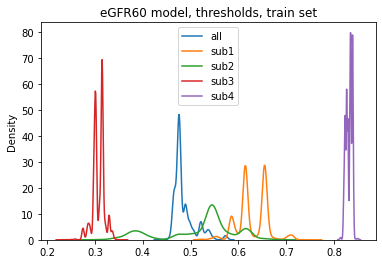

all-1-2-3-4
mean(ci): 0.49 (0.46-0.54), median:0.48
mean(ci): 0.63 (0.56-0.70), median:0.62
mean(ci): 0.52 (0.36-0.62), median:0.54
mean(ci): 0.31 (0.28-0.33), median:0.31
mean(ci): 0.83 (0.82-0.84), median:0.83


In [35]:
# Kernel Density Estimate Plot  
sns.kdeplot(th_box_train_all, label='all')
sns.kdeplot(th_box_train_sub1, label='sub1')
sns.kdeplot(th_box_train_sub2, label='sub2')
sns.kdeplot(th_box_train_sub3, label='sub3')
sns.kdeplot(th_box_train_sub4, label='sub4')

plt.title("eGFR60 model, thresholds, train set")
#plt.xlim(0.8,1)
plt.legend()
plt.show()

print('all-1-2-3-4')
cical(th_box_train_all)
cical(th_box_train_sub1)
cical(th_box_train_sub2)
cical(th_box_train_sub3)
cical(th_box_train_sub4)

## Internal Validation

In [36]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

In [37]:
# for logistic regression, data
lr = X_test.copy()
lr[['std_age', 'std_uph', 'std_usg']] = X_test_features[std_cols]
#lr.to_csv("/home/danssa/proj_ua/data/df_lr_chasv.v1.csv", encoding='utf-8', index=False)

In [40]:
# dataframe for bootstrap
y_prob = model_new.predict_proba(X_test_features)[:,1]
df_test = X_test.copy()
df_test['prob'] = y_prob

test_all = df_test.copy()
test_sub1 = df_test.query('dm==1')
test_sub2 = df_test.query('htn==1')
test_sub3 = df_test.query('age<65')
test_sub4 = df_test.query('age>=65')

In [41]:
print('test set')
print('total cases, prevalence (cases)')
print('test  all: %d, %.1f (%d)' % (len(test_all), sum(test_all['eGFR_ab'])/len(test_all)*100, sum(test_all['eGFR_ab'])))
print('subgroup1: %d, %.1f (%d)' % (len(test_sub1), sum(test_sub1['eGFR_ab'])/len(test_sub1)*100, sum(test_sub1['eGFR_ab'])))
print('subgroup2: %d, %.1f (%d)' % (len(test_sub2), sum(test_sub2['eGFR_ab'])/len(test_sub2)*100, sum(test_sub2['eGFR_ab'])))
print('subgroup3: %d, %.1f (%d)' % (len(test_sub3), sum(test_sub3['eGFR_ab'])/len(test_sub3)*100, sum(test_sub3['eGFR_ab'])))
print('subgroup4: %d, %.1f (%d)' % (len(test_sub4), sum(test_sub4['eGFR_ab'])/len(test_sub4)*100, sum(test_sub4['eGFR_ab'])))

test set
total cases, prevalence (cases)
test  all: 66007, 6.8 (4462)
subgroup1: 1630, 4.5 (74)
subgroup2: 2642, 2.2 (58)
subgroup3: 55265, 2.7 (1471)
subgroup4: 10742, 27.8 (2991)


### test_all

In [43]:
# set dataset and threshold
data = test_all
threshold = mean(th_box_train_all)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_all = []
se_box_all = []
sp_box_all = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_all.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_all.append(se)
        sp_box_all.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [12:27<00:00, 13.38it/s]


In [45]:
print('test_all, bootstrap\nauc-se-sp')
cical(auc_box_all)
cical(se_box_all)
cical(sp_box_all)

test_all, bootstrap
auc-se-sp
mean(ci): 0.91 (0.91-0.92), median:0.91
mean(ci): 0.87 (0.86-0.88), median:0.87
mean(ci): 0.81 (0.81-0.82), median:0.81


### test_sub1, diabetes

In [46]:
# set dataset and threshold
data = test_sub1
threshold = mean(th_box_train_sub1)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub1 = []
se_box_sub1 = []
sp_box_sub1 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub1.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub1.append(se)
        sp_box_sub1.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:36<00:00, 274.81it/s]


In [47]:
print('test_sub1, bootstrap\nauc-se-sp')
cical(auc_box_sub1)
cical(se_box_sub1)
cical(sp_box_sub1)

test_sub1, bootstrap
auc-se-sp
mean(ci): 0.87 (0.82-0.91), median:0.87
mean(ci): 0.77 (0.68-0.86), median:0.77
mean(ci): 0.82 (0.80-0.83), median:0.81


### test_sub2, hypertension

In [48]:
# set dataset and threshold
data = test_sub2
threshold = mean(th_box_train_sub2)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub2 = []
se_box_sub2 = []
sp_box_sub2 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub2.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub2.append(se)
        sp_box_sub2.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:46<00:00, 216.79it/s]


In [49]:
print('test_sub2, bootstrap\nauc-se-sp')
cical(auc_box_sub2)
cical(se_box_sub2)
cical(sp_box_sub2)

test_sub2, bootstrap
auc-se-sp
mean(ci): 0.91 (0.87-0.94), median:0.91
mean(ci): 0.90 (0.81-0.97), median:0.90
mean(ci): 0.77 (0.76-0.79), median:0.77


### test_sub3, age<65

In [50]:
# set dataset and threshold
data = test_sub3
threshold = mean(th_box_train_sub3)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub3 = []
se_box_sub3 = []
sp_box_sub3 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub3.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub3.append(se)
        sp_box_sub3.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [10:12<00:00, 16.34it/s]


In [51]:
print('test_sub3, bootstrap\nauc-se-sp')
cical(auc_box_sub3)
cical(se_box_sub3)
cical(sp_box_sub3)

test_sub3, bootstrap
auc-se-sp
mean(ci): 0.89 (0.88-0.90), median:0.89
mean(ci): 0.80 (0.77-0.82), median:0.80
mean(ci): 0.82 (0.81-0.82), median:0.82


### test_sub4, age>=65

In [52]:
# set dataset and threshold
data = test_sub4
threshold = mean(th_box_train_sub4)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub4 = []
se_box_sub4 = []
sp_box_sub4 = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])    
        auc_box_sub4.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred)
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub4.append(se)
        sp_box_sub4.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [02:10<00:00, 76.60it/s]


In [53]:
print('test_sub4, bootstrap\nauc-se-sp')
cical(auc_box_sub4)
cical(se_box_sub4)
cical(sp_box_sub4)

test_sub4, bootstrap
auc-se-sp
mean(ci): 0.74 (0.73-0.75), median:0.74
mean(ci): 0.64 (0.63-0.66), median:0.64
mean(ci): 0.72 (0.71-0.73), median:0.72


## External Validation

In [55]:
#external validation in knhanes set

ev_wt = pd.read_csv("/home/danssa/proj_ua/data/knhanes_12y.v1.csv").query('age>=18&age<80')

ev = df[(df['from']=="knhanes") & (df['age']>=18) & (df['age']<80)]
ev['eGFR_ab'] = np.where(ev['eGFR_ckd']<60,1,0)
ev['wt'] = np.array(ev_wt['wt_12y'])

y_test_ev = ev['eGFR_ab']
print("\nev cases=%d, p cases=%d, ratio=%.2f" % (ev.shape[0], sum(y_test_ev), sum(y_test_ev)/ev.shape[0]*100))

X_test_features_ev = ev.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df = X_test_features_ev[std_cols]
X_test_features_ev[std_cols] = scaler.transform(std_df)
print(X_test_features_ev.shape)
X_test_features_ev.describe()


ev cases=62945, p cases=1940, ratio=3.08
(62945, 7)


,male,he_usg,he_uph,he_ubld,he_uglu,he_upro,age
count,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000
mean,0.451696,0.051608,-0.527063,0.579458,0.094305,0.117039,0.142240
std,0.497665,0.784656,1.005067,1.027015,0.539820,0.409067,1.030399
min,0.000000,-1.720897,-1.435489,0.000000,0.000000,0.000000,-1.875173
25%,0.000000,-0.457367,-1.435489,0.000000,0.000000,0.000000,-0.654308
50%,0.000000,0.174398,-0.829085,0.000000,0.000000,0.000000,0.181020
75%,1.000000,0.806162,0.383723,1.000000,0.000000,0.000000,0.952092
max,1.000000,1.437927,3.415742,5.000000,5.000000,5.000000,2.044445


In [56]:
# dataframe for bootstrap, external validation set
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
df_test_ev = ev.copy()
df_test_ev['prob'] = y_prob_ev

test_all_ev = df_test_ev.copy()
test_sub1_ev = df_test_ev.query('dm==1')
test_sub2_ev = df_test_ev.query('htn==1')
test_sub3_ev = df_test_ev.query('age<65')
test_sub4_ev = df_test_ev.query('age>=65')

In [92]:
print('external validation set, knhanes')
print('total cases, prevalence (cases)')
print('all      : %d, %.1f (%d)' % (sum(test_all_ev['wt']), sum(test_all_ev.query('eGFR_ab==1')['wt'])/sum(test_all_ev['wt'])*100, sum(test_all_ev.query('eGFR_ab==1')['wt'])))
print('subgroup1: %d, %.1f (%d)' % (sum(test_sub1_ev['wt']), sum(test_sub1_ev.query('eGFR_ab==1')['wt'])/sum(test_sub1_ev['wt'])*100, sum(test_sub1_ev.query('eGFR_ab==1')['wt'])))
print('subgroup2: %d, %.1f (%d)' % (sum(test_sub2_ev['wt']), sum(test_sub2_ev.query('eGFR_ab==1')['wt'])/sum(test_sub2_ev['wt'])*100, sum(test_sub2_ev.query('eGFR_ab==1')['wt'])))
print('subgroup3: %d, %.1f (%d)' % (sum(test_sub3_ev['wt']), sum(test_sub3_ev.query('eGFR_ab==1')['wt'])/sum(test_sub3_ev['wt'])*100, sum(test_sub3_ev.query('eGFR_ab==1')['wt'])))
print('subgroup4: %d, %.1f (%d)' % (sum(test_sub4_ev['wt']), sum(test_sub4_ev.query('eGFR_ab==1')['wt'])/sum(test_sub4_ev['wt'])*100, sum(test_sub4_ev.query('eGFR_ab==1')['wt'])))

external validation set, knhanes
total cases, prevalence (cases)
all      : 35469798, 2.0 (726038)
subgroup1: 3001786, 8.5 (255630)
subgroup2: 8499212, 5.8 (488990)
subgroup3: 30970242, 0.7 (217567)
subgroup4: 4499556, 11.3 (508470)


### test_all_ev

In [60]:
# set dataset and threshold
data = test_all_ev
threshold = mean(th_box_train_all)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_all_ev = []
se_box_all_ev = []
sp_box_all_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_all_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_all_ev.append(se)
        sp_box_all_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [11:53<00:00, 14.02it/s]


In [61]:
print('test_all_ev, bootstrap\nauc-se-sp')
cical(auc_box_all_ev)
cical(se_box_all_ev)
cical(sp_box_all_ev)

test_all_ev, bootstrap
auc-se-sp
mean(ci): 0.92 (0.91-0.93), median:0.92
mean(ci): 0.88 (0.86-0.90), median:0.88
mean(ci): 0.82 (0.82-0.83), median:0.82


### test_sub1_ev, diabetes

In [62]:
# set dataset and threshold
data = test_sub1_ev
threshold = mean(th_box_train_sub1)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub1_ev = []
se_box_sub1_ev = []
sp_box_sub1_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub1_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub1_ev.append(se)
        sp_box_sub1_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:26<00:00, 115.16it/s]


In [63]:
print('test_sub1_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub1_ev)
cical(se_box_sub1_ev)
cical(sp_box_sub1_ev)

test_sub1_ev, bootstrap
auc-se-sp
mean(ci): 0.81 (0.79-0.83), median:0.81
mean(ci): 0.80 (0.76-0.83), median:0.80
mean(ci): 0.67 (0.66-0.68), median:0.67


### test_sub2_ev, hypertension

In [64]:
# set dataset and threshold
data = test_sub2_ev
threshold = mean(th_box_train_sub2)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub2_ev = []
se_box_sub2_ev = []
sp_box_sub2_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub2_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub2_ev.append(se)
        sp_box_sub2_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [03:22<00:00, 49.33it/s]


In [65]:
print('test_sub2_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub2_ev)
cical(se_box_sub2_ev)
cical(sp_box_sub2_ev)

test_sub2_ev, bootstrap
auc-se-sp
mean(ci): 0.84 (0.83-0.86), median:0.84
mean(ci): 0.89 (0.87-0.91), median:0.89
mean(ci): 0.63 (0.62-0.63), median:0.63


### test_sub3_ev, age<65

In [66]:
# set dataset and threshold
data = test_sub3_ev
threshold = mean(th_box_train_sub3)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub3_ev = []
se_box_sub3_ev = []
sp_box_sub3_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub3_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub3_ev.append(se)
        sp_box_sub3_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [09:02<00:00, 18.43it/s]


In [67]:
print('test_sub3_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub3_ev)
cical(se_box_sub3_ev)
cical(sp_box_sub3_ev)

test_sub3_ev, bootstrap
auc-se-sp
mean(ci): 0.90 (0.89-0.91), median:0.90
mean(ci): 0.83 (0.79-0.87), median:0.83
mean(ci): 0.78 (0.78-0.78), median:0.78


### test_sub4_ev, age>=65

In [68]:
# set dataset and threshold
data = test_sub4_ev
threshold = mean(th_box_train_sub4)

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_sub4_ev = []
se_box_sub4_ev = []
sp_box_sub4_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
        auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])    
        auc_box_sub4_ev.append(auc)
        
        y_prob_pred = (boot['prob']>threshold).astype('int')
        cm = confusion_matrix(boot['eGFR_ab'], y_prob_pred, sample_weight=boot['wt'])
        se = cm[1][1]/(cm[1][1]+cm[1][0])
        sp = 1-cm[0][1]/(cm[0][1]+cm[0][0])
        se_box_sub4_ev.append(se)
        sp_box_sub4_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [02:35<00:00, 64.28it/s]


In [69]:
print('test_sub4_ev, bootstrap\nauc-se-sp')
cical(auc_box_sub4_ev)
cical(se_box_sub4_ev)
cical(sp_box_sub4_ev)

test_sub4_ev, bootstrap
auc-se-sp
mean(ci): 0.69 (0.67-0.70), median:0.69
mean(ci): 0.50 (0.47-0.53), median:0.50
mean(ci): 0.76 (0.75-0.77), median:0.76


## ROC curve, internal and external set

In [97]:
#function of finding the index nearest train mean threshold
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

### internal, all

eGFR60 model

Classification Report

Best Threshold=0.473, sensitivity = 0.87, specificity = 0.81, J=0.682
              precision    recall  f1-score   support

      normal       0.99      0.81      0.89     61545
    abnormal       0.25      0.87      0.39      4462

    accuracy                           0.81     66007
   macro avg       0.62      0.84      0.64     66007
weighted avg       0.94      0.81      0.86     66007



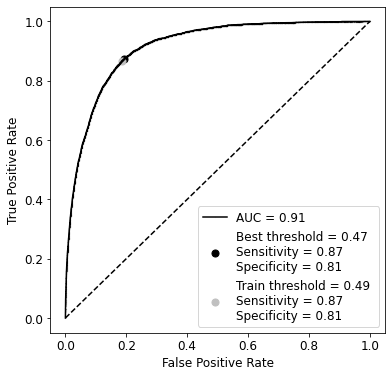

In [100]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = df_test['prob']
y_test = df_test['eGFR_ab']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
# obtain the nearest train best threshold
n_th_test_all, idx = find_nearest(thresholds, mean(th_box_train_all))

print('eGFR60 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob > best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
n_sens, n_spec = tpr[idx], 1-fpr[idx]

# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 12
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))
plt.scatter(fpr[idx], tpr[idx], marker='o', s=50, color='silver', 
            label='Train threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (n_th_test_all, n_sens, n_spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

### external, all

eGFR60 model, knhanes, external validation

Classification Report

Best Threshold=0.497, sensitivity = 0.88, specificity = 0.83, J=0.703
              precision    recall  f1-score   support

      normal       1.00      0.83      0.90 34743760.49391329
    abnormal       0.10      0.88      0.17 726038.3826888512

    accuracy                           0.83 35469798.87660214
   macro avg       0.55      0.85      0.54 35469798.87660214
weighted avg       0.98      0.83      0.89 35469798.87660214



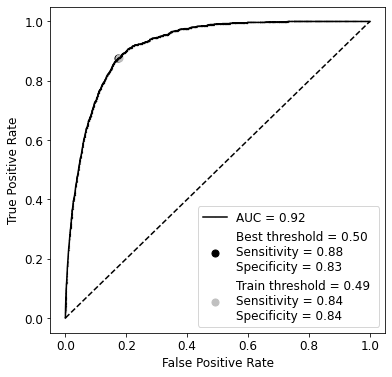

In [101]:
# external validation 

# Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_ev = df_test_ev['prob']
# calculate roc curves
fpr_ev, tpr_ev, thresholds_ev = roc_curve(y_test_ev, y_prob_ev, sample_weight=ev['wt'])
# get the best threshold
J_ev = tpr_ev - fpr_ev
ix_ev = argmax(J_ev)
best_thresh_ev = thresholds_ev[ix_ev]
# obtain the nearest train best threshold
n_th_test_all_ev, idx_ev = find_nearest(thresholds_ev, mean(th_box_train_all))

print('eGFR60 model, knhanes, external validation')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_ev, tpr_ev[ix_ev], 1-fpr_ev[ix_ev], J_ev[ix_ev]))

y_prob_pred_ev = (y_prob_ev > best_thresh_ev).astype(bool)
print(classification_report(y_test_ev, y_prob_pred_ev, target_names=['normal', 'abnormal'], sample_weight=ev['wt']))

#plot roc and best threshold
sens_ev, spec_ev = tpr_ev[ix_ev], 1-fpr_ev[ix_ev]
n_sens_ev, n_spec_ev = tpr[idx_ev], 1-fpr[idx_ev]

# plot the roc curve for the model
#plt.rcParams["figure.figsize"] = (10,10)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_ev, tpr_ev, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(fpr_ev[ix_ev], tpr_ev[ix_ev], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_ev, sens_ev, spec_ev))
plt.scatter(fpr_ev[idx_ev], tpr_ev[idx_ev], marker='o', s=50, color='silver', 
            label='Train threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (n_th_test_all_ev, n_sens_ev, n_spec_ev))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

### both internal and external

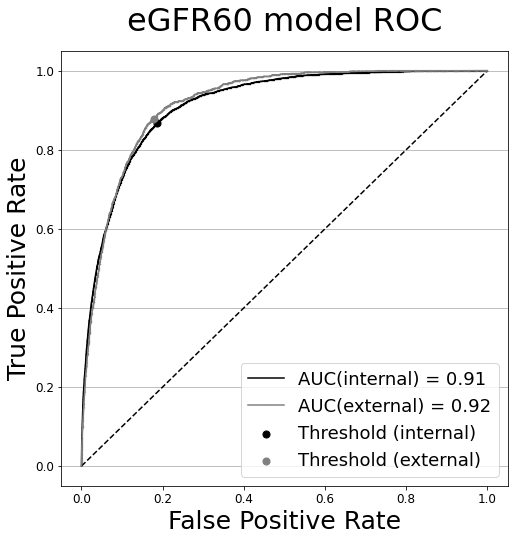

In [93]:
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (8,8)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC(internal) = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(1-mean(sp_box_all), mean(se_box_all), marker='o', s=50, color='k'
            , label='Threshold (internal)' 
            #% (best_thresh)
           )

plt.plot(fpr_ev, tpr_ev, marker='.', color='grey', markersize=0.05, label="AUC(external) = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(1-mean(sp_box_all_ev), mean(se_box_all_ev), marker='o', s=50, color='grey'
            , label='Threshold (external)' 
            #% (best_thresh_ev)
           )

# axis labels
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.legend(loc=4, fontsize=18)
plt.title('eGFR60 model ROC', size=32, pad=20)
# show the plot
#plt.show()

plt.grid(axis='y')
#plt.ylim(1.0)
# save as png
#plt.savefig('/home/danssa/proj_ua/images/5sub/60model_roc.png', dpi=300)

### sub4, age>=65

eGFR60 model

Classification Report

Best Threshold=0.836, sensitivity = 0.63, specificity = 0.74, J=0.368
              precision    recall  f1-score   support

      normal       0.84      0.74      0.78      7751
    abnormal       0.48      0.63      0.55      2991

    accuracy                           0.71     10742
   macro avg       0.66      0.68      0.66     10742
weighted avg       0.74      0.71      0.72     10742



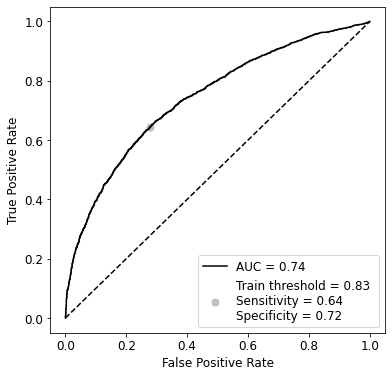

In [104]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = test_sub4['prob']
y_test = test_sub4['eGFR_ab']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
# obtain the nearest train best threshold
n_th_test_sub4, idx = find_nearest(thresholds, mean(th_box_train_sub4))

print('eGFR60 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob > best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
n_sens, n_spec = tpr[idx], 1-fpr[idx]

# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 12
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
#plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
#            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))
plt.scatter(fpr[idx], tpr[idx], marker='o', s=50, color='silver', 
            label='Train threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (n_th_test_sub4, n_sens, n_spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

## SHAP value

In [81]:
#SHAP value 

shap.initjs()
print(shap.__version__)

names = pd.read_csv('~/proj_ua/data/knhanes_urine_explain_10types.csv', index_col='var')
background = shap.maskers.Independent(X_train_features_new, max_samples=100)
explainer = shap.TreeExplainer(model_new, model_output='probability', data=X_train_features_new)
shap_values = explainer.shap_values(X_train_features_new)
meaning_dict = names.to_dict()['name']

0.37.0


100%|===================| 153923/154013 [13:06<00:00]        

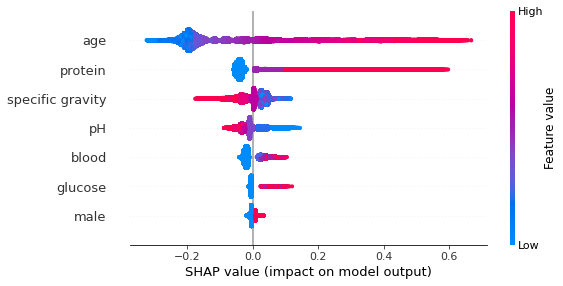

In [82]:
# SHAP, train set
shap.summary_plot(shap_values, X_train_features_new.rename(columns=meaning_dict))

In [83]:
#shap gray version configuration
import matplotlib.colors as colors

gray_val=0.75
cdict = {'red': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)],
        'green': [(0.0, gray_val, gray_val),
                 (1.0, 0.0, 0.0)],
        'blue': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)]}
gray2black = colors.LinearSegmentedColormap(name='red', segmentdata=cdict)

In [84]:
# SHAP,test all
shap_values_all = explainer.shap_values(X_test_features)

100%|===================| 65995/66007 [05:37<00:00]        

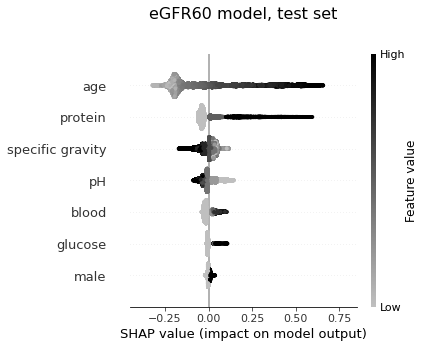

In [85]:
shap.summary_plot(shap_values_all, X_test_features.rename(columns=meaning_dict), show=False, 
                  cmap=plt.get_cmap(gray2black)
                 )
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(6)

plt.xlim([-0.45,0.85])
plt.title('eGFR60 model, test set', fontsize=16, pad=35)
plt.tight_layout()

plt.grid('off')
plt.grid(b=None)

#save as png
#plt.savefig('/home/danssa/proj_ua/images/5sub/60model_shap.png', dpi=300)

## accuracy(sensitivity) : eGFR<60, eGFR<45 and eGFR<30

### internal

### all

In [87]:
test_all['pred'] = np.where(test_all['prob']>mean(th_box_train_all), 1, 0)
test_all['pred'].value_counts()

# 60
test_all = test_all.query('eGFR_ckd<60')
test_all['acc'] = test_all['eGFR_ab'] == test_all['pred']
print('60all: %d right: %d ratio: %.1f' % (len(test_all), sum(test_all['acc']), sum(test_all['acc'])/len(test_all)*100))

#45
test_all45 = test_all.query('eGFR_ckd<45')
test_all45['eGFR_ab45'] = np.where(test_all45['eGFR_ckd']<45,1,0)
test_all45['acc'] = test_all45['eGFR_ab45'] == test_all45['pred']
print('45all: %d right: %d ratio: %.1f' % (len(test_all45), sum(test_all45['acc']), sum(test_all45['acc'])/len(test_all45)*100))

#30
test_all30 = test_all.query('eGFR_ckd<30')
test_all30['eGFR_ab30'] = np.where(test_all30['eGFR_ckd']<30,1,0)
test_all30['acc'] = test_all30['eGFR_ab30'] == test_all30['pred']
print('30all: %d right: %d ratio: %.1f' % (len(test_all30), sum(test_all30['acc']), sum(test_all30['acc'])/len(test_all30)*100))

60all: 4462 right: 3870 ratio: 86.7
45all: 1954 right: 1811 ratio: 92.7
30all: 915 right: 872 ratio: 95.3


In [88]:
# test set
data = test_all

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_all_60, acc = [], []
se_all_45, acc45 = [], []
se_all_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_all_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_all_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_all_30.append(se30)
        
        pbar.update()

10000it [01:12, 137.13it/s]                         


In [89]:
print('all, 60-45-30')
cical(se_all_60)
cical(se_all_45)
cical(se_all_30)

all, 60-45-30
mean(ci): 0.87 (0.86-0.87), median:0.87
mean(ci): 0.93 (0.92-0.94), median:0.93
mean(ci): 0.95 (0.94-0.97), median:0.95


In [107]:
len(X_test.query('eGFR_ab==1&age>=65'))/len(X_test.query('eGFR_ab==1'))

0.6703272075302555